The Toxic comment classification project aims at predicting a comment as posted on online platforms to be toxic and at varous levels like toxic, severe toxic, insult, obscene , threat and identity hate. The solution will help identify a toxic comment so that administrative actions can be taken and the toxic comment be removed from the platform to to reduce damage to online interactions. The problem is a classic classification problem of identifyting whether a text has toxicity. The data source to design and create a model is the coversation and comment history from Wikipedia, where user comments have been lableled by human actors to inidcate the level of toxicity , if present in the dataset.

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/jigsaw-toxic-comment-classification-challenge/test_labels.csv.zip
/kaggle/input/jigsaw-toxic-comment-classification-challenge/train.csv.zip
/kaggle/input/jigsaw-toxic-comment-classification-challenge/test.csv.zip
/kaggle/input/jigsaw-toxic-comment-classification-challenge/sample_submission.csv.zip


In [ ]:
%matplotlib inline
from keras import *

Lets first load the data for the train and test set

In [ ]:
train = pd.read_csv('/kaggle/input/jigsaw-toxic-comment-classification-challenge/train.csv.zip')
test = pd.read_csv('/kaggle/input/jigsaw-toxic-comment-classification-challenge/test.csv.zip')


I will do some now do some EDA to get an idea of the training data, first sample, then columns, then shape and finally to see if we have any null conent on any columns that can impact our model.

In [ ]:
train.sample(5)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
115941,6be616c9a8d17672,"""\n\n Guinness \n\nHi. I found you in the Wiki...",0,0,0,0,0,0
14758,26f9e5d1b6b6ada1,"Actually, butlers do buttle, though this is a ...",0,0,0,0,0,0
114639,6528541cae23d52f,", first is in relation to Quiver_(mathematics)...",0,0,0,0,0,0
90469,f21980cd133f147b,CBNG irc reporting request \n\nI would like a...,0,0,0,0,0,0
128482,af29e818d6fda430,why you blocking when i am fixing the pages? \...,0,0,0,0,0,0


In [ ]:
train.columns

Index(['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat',
       'insult', 'identity_hate'],
      dtype='object')

In [ ]:
train.shape

(159571, 8)

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             159571 non-null  object
 1   comment_text   159571 non-null  object
 2   toxic          159571 non-null  int64 
 3   severe_toxic   159571 non-null  int64 
 4   obscene        159571 non-null  int64 
 5   threat         159571 non-null  int64 
 6   insult         159571 non-null  int64 
 7   identity_hate  159571 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 9.7+ MB


The data thus looks good, free of any null content. There are 8 columns, including id, comment text followed by six levels toxicity indicated by number.

In [ ]:
train.toxic.describe()

count    159571.000000
mean          0.095844
std           0.294379
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: toxic, dtype: float64

You wont like to read the output of the follwoing but i wanted to see the data. Converting it to count, to remove the actual messages.

In [ ]:
train.loc[train['toxic']==1].count()
train.loc[train['toxic']==0].count()
train.loc[train['toxic']<1].count()
train.loc[train['toxic']==1].count()

id               15294
comment_text     15294
toxic            15294
severe_toxic     15294
obscene          15294
threat           15294
insult           15294
identity_hate    15294
dtype: int64

Lets plot individual comment type toxicity to get an idea

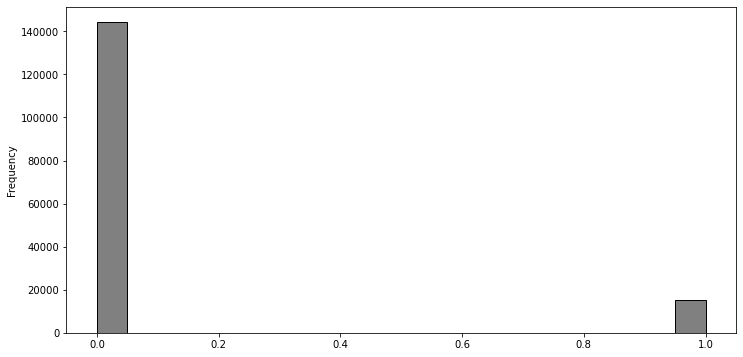

In [ ]:
train['toxic'].plot(kind = 'hist' , bins =20, figsize=(12,6), facecolor='grey', edgecolor='black')

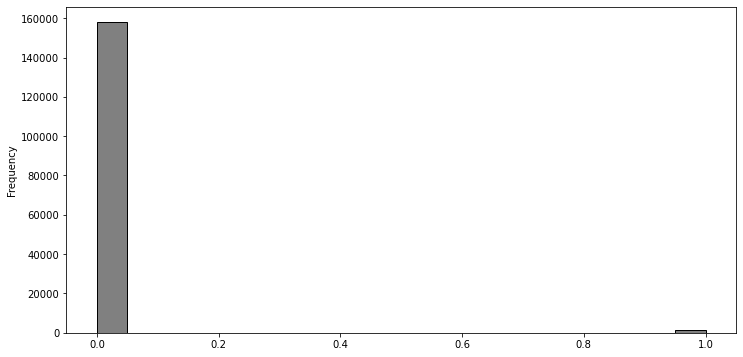

In [ ]:
train['severe_toxic'].plot(kind = 'hist' , bins =20, figsize=(12,6), facecolor='grey', edgecolor='black')

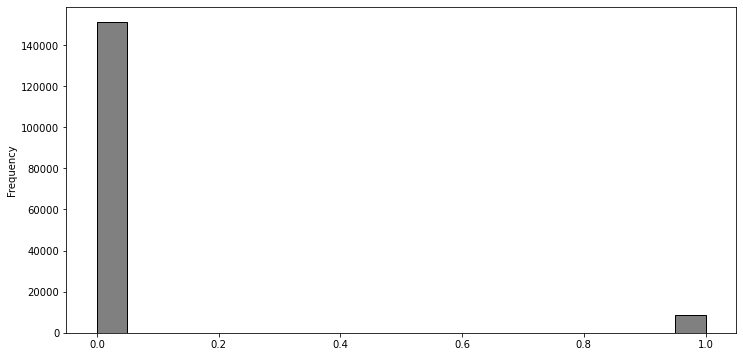

In [ ]:
train['obscene'].plot(kind = 'hist' , bins =20, figsize=(12,6), facecolor='grey', edgecolor='black')          

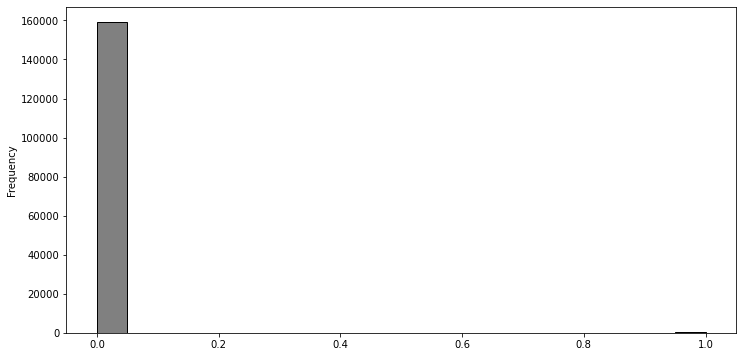

In [ ]:
train['threat'].plot(kind = 'hist' , bins =20, figsize=(12,6), facecolor='grey', edgecolor='black')  

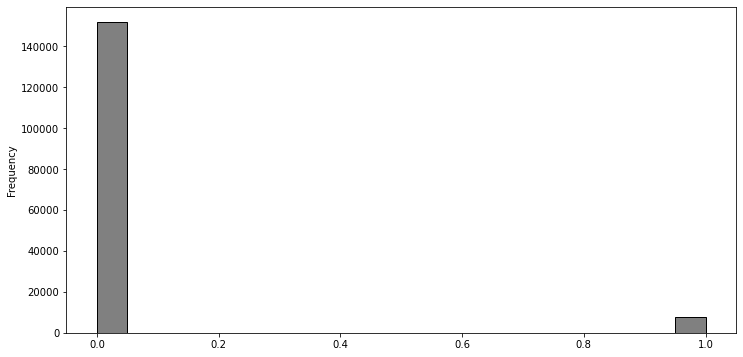

In [ ]:
train['insult'].plot(kind = 'hist' , bins =20, figsize=(12,6), facecolor='grey', edgecolor='black')  

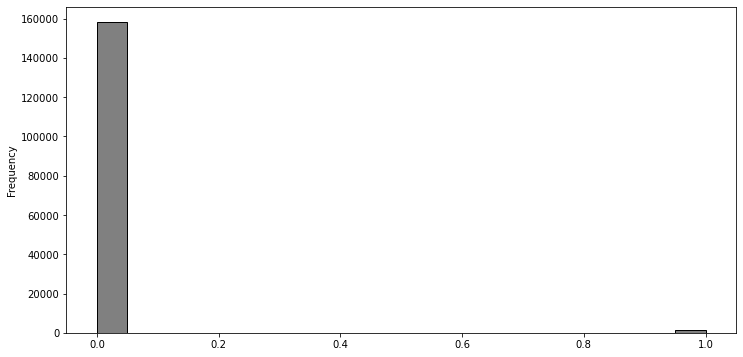

In [ ]:
train['identity_hate'].plot(kind = 'hist' , bins =20, figsize=(12,6), facecolor='grey', edgecolor='black')  

I think we are good with our initial EDA. We dont need to go any further as these features have no independence and we are using this data for classification on one of these comment category.

In [ ]:
comment_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult","identity_hate"]
y=train[comment_classes].values
comment_text_train = train["comment_text"]
comment_text_test = train["comment_text"]

As discussed ealrier now we will use Kera to tokenize each word and convert it to an index for the dictionary of words from wikipedia. Lets intitialize the system for 20000 words, fit to train and then convert all the comments into sequences of the index of words.

In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers
tokenizer = Tokenizer(num_words=20000)
tokenizer.fit_on_texts(list(comment_text_train))
tokenized_train = tokenizer.texts_to_sequences(comment_text_train)
tokenized_test = tokenizer.texts_to_sequences(comment_text_test)

In [ ]:
tokenized_train[:1]

[[688,
  75,
  1,
  126,
  130,
  177,
  29,
  672,
  4511,
  12052,
  1116,
  86,
  331,
  51,
  2278,
  11448,
  50,
  6864,
  15,
  60,
  2756,
  148,
  7,
  2937,
  34,
  117,
  1221,
  15190,
  2825,
  4,
  45,
  59,
  244,
  1,
  365,
  31,
  1,
  38,
  27,
  143,
  73,
  3462,
  89,
  3085,
  4583,
  2273,
  985]]

Since every comment can be of different length, lets calculate the length of senetence for the set.

In [ ]:
wordsInComment = [len(comment) for comment in tokenized_train]
wordsInComment

[47,
 17,
 42,
 114,
 13,
 11,
 8,
 19,
 84,
 11,
 499,
 11,
 51,
 143,
 38,
 104,
 10,
 3,
 17,
 76,
 40,
 9,
 81,
 13,
 219,
 16,
 49,
 58,
 27,
 13,
 17,
 11,
 11,
 146,
 55,
 141,
 184,
 56,
 25,
 206,
 35,
 37,
 106,
 8,
 60,
 123,
 12,
 19,
 118,
 183,
 454,
 24,
 32,
 89,
 8,
 19,
 12,
 111,
 312,
 66,
 18,
 55,
 5,
 164,
 29,
 57,
 17,
 30,
 38,
 33,
 32,
 61,
 11,
 217,
 32,
 9,
 41,
 50,
 30,
 13,
 173,
 473,
 94,
 53,
 17,
 22,
 13,
 8,
 58,
 4,
 148,
 69,
 17,
 16,
 91,
 92,
 10,
 22,
 30,
 51,
 13,
 19,
 16,
 76,
 13,
 7,
 149,
 104,
 24,
 21,
 15,
 8,
 109,
 73,
 225,
 10,
 98,
 26,
 48,
 7,
 38,
 53,
 44,
 30,
 22,
 24,
 527,
 32,
 38,
 76,
 41,
 27,
 50,
 35,
 108,
 34,
 15,
 44,
 8,
 8,
 158,
 67,
 320,
 56,
 21,
 115,
 6,
 36,
 80,
 71,
 119,
 92,
 10,
 79,
 18,
 40,
 25,
 52,
 41,
 18,
 538,
 41,
 418,
 15,
 28,
 31,
 115,
 152,
 26,
 65,
 57,
 10,
 75,
 5,
 32,
 5,
 26,
 13,
 18,
 126,
 226,
 10,
 6,
 35,
 24,
 25,
 22,
 18,
 46,
 41,
 46,
 66,
 44,
 14,
 9,
 47,
 3

LEts visualize the comment lengths now

(array([21439., 27127., 22176., 16223., 12859., 10062.,  7586.,  5991.,
         4731.,  3914.,  3129.,  2820.,  2306.,  1896.,  1647.,  1455.,
         1329.,  1287.,  1013.,   857.,   750.,   799.,   528.,   581.,
          486.,   437.,   407.,   373.,   416.]),
 array([  0,  10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120,
        130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250,
        260, 270, 280, 290]),
 <a list of 29 Patch objects>)

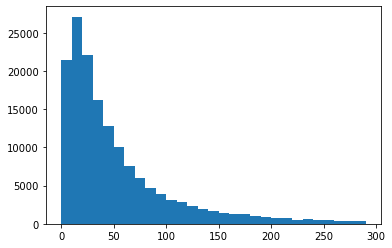

In [ ]:
import matplotlib.pyplot as plt
plt.hist(wordsInComment, bins = np.arange(0,300,10))

Which shows must comments are approximately 20 -40 words. Lets consider 200 as max words. We may have to know padd to fill the rest of the comment with empty text so that the length is constant for the model.

In [ ]:
X_t = pad_sequences(tokenized_train, maxlen=200)
X_te = pad_sequences(tokenized_test, maxlen=200)

Now we define a input as list of comments with length 200

In [ ]:
inp = Input(shape=(200, ))
embed_size = 128
x = Embedding(20000, embed_size)(inp)

In [ ]:
x = LSTM(60, return_sequences=True,name='lstm_layer')(x)
x = GlobalMaxPool1D()(x)
x = Dropout(0.1)(x)
x = Dense(50, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(6, activation="sigmoid")(x)


Utilizing a cross entorpy with adam optimizer model

In [ ]:
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

Selecting a batch size of 32 and iteration/epoch 2

In [ ]:
batch_size = 32
epochs = 2
model.fit(X_t,y, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Epoch 1/2
4488/4488 [==============================] - 671s 150ms/step - loss: 0.0732 - accuracy: 0.9409 - val_loss: 0.0489 - val_accuracy: 0.9940
Epoch 2/2
4488/4488 [==============================] - 653s 146ms/step - loss: 0.0454 - accuracy: 0.9897 - val_loss: 0.0475 - val_accuracy: 0.9928


We can see that the model is validated with a classification accuracy of 99.28  %. 